## Correlation search with map reduce

In [1]:
import pandas as pd
import numpy as np

In [8]:
class MapReduceAbstract(object):
    def __init__(self):
        pass

    def map(self, df_batch):
        raise NotImplementedError("Should have implemented this")

    def reduce(self, x, result):
        raise NotImplementedError("Should have implemented this")

    def filter(self, df_batch):
        raise NotImplementedError("Should have implemented this")

class ItemFamilyAggregationMapReduce(MapReduceAbstract):
    def __init__(self, items):
        self.items = items
    
    def filter(self, df_batch):
        return df_batch
    
    def map(self, df_batch):
        df_items = df_batch.merge(self.items[['item_nbr', 'family']], on='item_nbr')
        df_aggregated = df_items.groupby(['family', 'date'], as_index=False).agg({'unit_sales':'sum'})

        # filling empty values
        u_dates = df_batch.date.unique()
        u_families = self.items.family.unique()
        df_aggregated.set_index(["date", "family"], inplace=True)
        df_aggregated = df_aggregated.reindex(
            pd.MultiIndex.from_product(
                (u_dates, u_families),
                names=["date", "family"]
            )
        )
        df_aggregated.loc[:, "unit_sales"].fillna(0, inplace=True)
        return df_aggregated
        
    def reduce(self, df_aggregated, df_aggregated_prev):
        df_reduce = df_aggregated_prev.merge(df_aggregated, right_index=True, left_index=True, how='outer')
        df_reduce.fillna(0.0, inplace=True)
        df_reduce['unit_sales'] = df_reduce['unit_sales_x'] + df_reduce['unit_sales_y']
        del df_reduce['unit_sales_x']
        del df_reduce['unit_sales_y']
        return df_reduce
        
        
def print_if_verbose(s, verbose):
    if verbose:
        print(s)


def map_reduce_df(csv_path, map_reduce_object, types=None, position=0, batch_size=10000000, cols=None, verbose=False):
    result = None
    if position != 0 and cols is None:
        raise ValueError("You should either start from position 0 or specify cols.")

    while True:
        print_if_verbose('Reading batch from position {}, batch size {}...'.format(position, batch_size), verbose)
        try:
            if position == 0:
                df = pd.read_csv(csv_path, dtype=types, nrows=batch_size, skiprows=position)
                cols = df.columns
            else:
                df = pd.read_csv(csv_path, dtype=types, nrows=batch_size, skiprows=position, names=cols, header=None)
        except Exception as e:
            print_if_verbose('End of dataset is found. Exception {}.'.format(e), verbose)
            break

        if len(df) == 0:
            print_if_verbose('End of dataset is found. Dataset is empty.', verbose)
            break

        print_if_verbose('Filtering {}...'.format(len(df)), verbose)
        df_filtered = map_reduce_object.filter(df)
        print_if_verbose('Filtered {}, mapping...'.format(len(df_filtered)), verbose)

        try:
            mapped = map_reduce_object.map(df_filtered)
        except Exception as e:
            print(e)
            print('Position: {}'.format(position))
            return result

        print_if_verbose('Mapped, reducing...', verbose)
        
        if result is None:
            result = mapped
        else:
            try:
                result = map_reduce_object.reduce(mapped, result)
            except Exception as e:
                print(e)
                print('Position: {}'.format(position))
                return result

        print_if_verbose('Batch done.', verbose)

        if len(df) + 1 < batch_size:
            print_if_verbose('End of dataset is found.', verbose)
            break

        position += batch_size

    return result

In [9]:
items = pd.read_csv('./data/items.csv')
mapreduce = ItemFamilyAggregationMapReduce(items[['item_nbr', 'family']])
types = {'id': 'int32',
         'date': 'int16',
         'item_nbr': 'int32',
         'store_nbr': 'int16',
         'unit_sales': 'float32',
         'onpromotion': bool}

agg_family = map_reduce_df('./data/train_processed.csv', mapreduce, types=types, verbose=True, batch_size=10000000)

Reading batch from position 0, batch size 5000000...
Filtering 5000000...
Filtered 5000000, mapping...
Mapped, reducing...
Batch done.
Reading batch from position 5000000, batch size 5000000...
Filtering 5000000...
Filtered 5000000, mapping...
Mapped, reducing...
Batch done.
Reading batch from position 10000000, batch size 5000000...
Filtering 5000000...
Filtered 5000000, mapping...
Mapped, reducing...
Batch done.
Reading batch from position 15000000, batch size 5000000...
Filtering 5000000...
Filtered 5000000, mapping...
Mapped, reducing...
Batch done.
Reading batch from position 20000000, batch size 5000000...
Filtering 5000000...
Filtered 5000000, mapping...
Mapped, reducing...
Batch done.
Reading batch from position 25000000, batch size 5000000...
Filtering 5000000...
Filtered 5000000, mapping...
Mapped, reducing...
Batch done.
Reading batch from position 30000000, batch size 5000000...
Filtering 5000000...
Filtered 5000000, mapping...
Mapped, reducing...
Batch done.
Reading batch 

In [10]:
agg_family.head(20)

unit_sales
date family                         
0    AUTOMOTIVE              0.00000
     BABY CARE               0.00000
     BEAUTY                  2.00000
     BEVERAGES             810.00000
     BOOKS                   0.00000
     BREAD/BAKERY          180.59375
     CELEBRATION             0.00000
     CLEANING              186.00000
     DAIRY                 143.00000
     DELI                   71.09082
     EGGS                   46.00000
     FROZEN FOODS           29.65625
     GROCERY I             700.00000
     GROCERY II             15.00000
     HARDWARE                0.00000
     HOME AND KITCHEN I      0.00000
     HOME AND KITCHEN II     0.00000
     HOME APPLIANCES         0.00000
     HOME CARE               0.00000
     LADIESWEAR              0.00000

In [11]:
agg_family.reset_index(inplace=True)

In [18]:
pivot = agg_family.pivot(index='date', columns='family', values='unit_sales')

In [19]:
pivot.head()

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,2.0,810.0,0.0,180.593750,0.0,186.0,143.0,71.090820,...,0.0,110.809570,25.0,0.0,0.0,42.638672,37.843750,0.0,0.0,0.000000
1,255.0,0.0,207.0,72092.0,0.0,26246.406250,0.0,74629.0,23381.0,15754.502930,...,0.0,20871.568359,17204.0,0.0,0.0,13976.088867,5338.113281,0.0,0.0,1526.711182
2,161.0,0.0,125.0,52105.0,0.0,18456.468750,0.0,55893.0,18001.0,11172.404297,...,0.0,16597.271484,12568.0,0.0,0.0,10674.223633,3591.417969,0.0,0.0,1094.317383
3,169.0,0.0,133.0,54167.0,0.0,16722.000000,0.0,52064.0,18148.0,10143.231445,...,0.0,21626.498047,11303.0,0.0,0.0,10772.629883,4473.000000,0.0,0.0,1293.137451
4,342.0,0.0,191.0,77818.0,0.0,22367.835938,0.0,70128.0,23082.0,13734.951172,...,0.0,20879.083984,16819.0,0.0,0.0,13474.754883,5830.109375,0.0,0.0,1245.639648


In [20]:
corr = pivot.corr()
corr.head()

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
family,,,,,,,,,,,,,,,,,,,,,
AUTOMOTIVE,1.000000,0.422094,0.809358,0.785890,0.149908,0.827848,0.514050,0.854994,0.812147,0.846082,...,0.575547,0.490777,0.856893,0.652938,0.641210,0.688830,0.831453,0.543170,0.235484,0.616900
BABY CARE,0.422094,1.000000,0.590281,0.631907,0.352576,0.505366,0.580871,0.415390,0.545290,0.440127,...,0.625049,0.204215,0.452542,0.668806,0.635920,0.314106,0.365183,0.642199,0.251726,0.177411
BEAUTY,0.809358,0.590281,1.000000,0.853687,0.345572,0.827524,0.579316,0.815144,0.813620,0.795330,...,0.705707,0.455674,0.824000,0.790123,0.749814,0.605769,0.706023,0.660739,0.338701,0.496330
BEVERAGES,0.785890,0.631907,0.853687,1.000000,0.285193,0.835076,0.791626,0.780525,0.883505,0.799326,...,0.752406,0.429970,0.799939,0.923655,0.925588,0.693792,0.706798,0.874645,0.352855,0.504120
BOOKS,0.149908,0.352576,0.345572,0.285193,1.000000,0.203650,0.238668,0.161015,0.266155,0.191753,...,0.342101,0.107483,0.168632,0.334377,0.299754,0.137967,0.162096,0.263528,-0.011151,0.034698


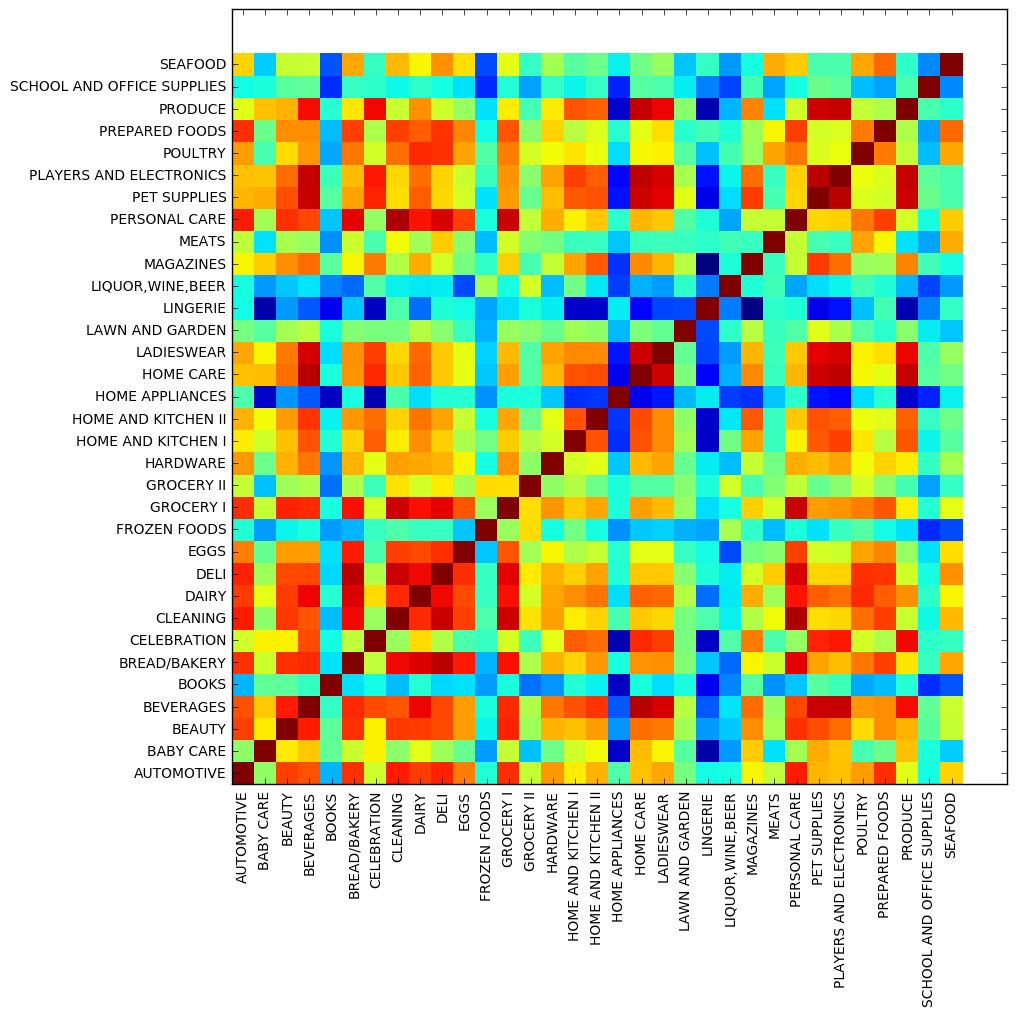

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)

plt.pcolor(corr)
plt.yticks(np.arange(0.5, len(corr.index), 1), corr.index)
locs, labels = plt.xticks(np.arange(0.5, len(corr.columns), 1), corr.columns)
plt.setp(labels, rotation=90)
plt.show()